# Word Embeddings (Word2Vec, Sent2Vec, and Doc2Vec)

In this project, I will implement a semantic search engine using the word2vec algorithm. I will use pre-trained word embeddings and build a search engine that can retrieve documents related to a given query based on semantic similarity.



## Dataset

The dataset used in this project comes from the StoryGraph project, which is a longitudinal collection of news similarity graphs from 17 US left, center, and right news media organizations. The corpus contains the following columns:

- `index` int: The unique identifier of the document.
- `source` str: The source of the document
- `title` str: The title of the document
- `text` str: The content of the article

```BibTeX
@MISC {nwala-cj20,
    author = {Alexander Nwala and Michele C. Weigle and Michael L. Nelson},
     title = {365 Dots in 2019: Quantifying Attention of News Sources},
     year = {2020},
      month = may,
     howpublished = {Poster/demo accepted at the Computation + Journalism Symposium (symposium cancelled due to COVID-19)},
     arxiv = {https://arxiv.org/abs/2003.09989},
     pubdate = {202005}
}
```

In [ ]:
import pandas as pd
import numpy as np

data_source = 'data/news-2023-02-01.csv'

articles = pd.read_csv(data_source)

### Dataset description

In [ ]:
articles.describe()

,source,title,text
count,11587,11586,11419
unique,20,716,1062
top,politicususa,Nicolle Wallace Devastates Trump And Shows Why...,Contact Us\nThis material may not be published...
freq,720,127,698


## Preprocessing

Clean, deduplicate, and tokenize the documents. You should be able to repurpose your code from the EDA assignment to do this.

In [ ]:
articles.head(10)

,source,title,text
0,politicususa,Prosecutors Pay Attention: Stormy Daniels Than...,Manhattan prosecutors are likely to notice tha...
1,politicususa,Investigators Push For Access To Trump Staff C...,Print\nInvestigators looking into Donald Trump...
2,politicususa,The End Is Near For George Santos As He Steps ...,The AP reported:\nRepublican Rep. George Santo...
3,politicususa,Rachel Maddow Cuts Trump To The Bone With Stor...,Rachel Maddow showed how Trump committed a cri...
4,vox,Alec Baldwin has been formally charged with in...,Candles are placed in front of a photo of cine...
5,vox,What layoffs at Google and other tech companie...,The path forward for tech workers won’t be eas...
6,vox,Did Republican Representative-elect George San...,New York Representative-elect George Santos sp...
7,vox,Sundance 2023: 17 movies to watch out for this...,Chiwetel Ejiofor and Emilia Clarke in The Pod ...
8,huffpost,Watch Trump Give Deposition In New York Civil ...,Watch Trump Give Deposition In New York Civil ...
9,huffpost,Ron DeSantis Plans To Defund Diversity Program...,Politics Florida Ron DeSantis higher education...


In [ ]:
data_drop = articles.drop_duplicates()

In [ ]:
data_clean = data_drop.dropna()

In [ ]:
data_clean['title'] = data_clean['title'].str.lower()
data_clean['text'] = data_clean['text'].str.lower()

<ipython-input-16-49d5f4b94086>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['title'] = data_clean['title'].str.lower()
<ipython-input-16-49d5f4b94086>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['text'] = data_clean['text'].str.lower()


In [ ]:
#tokenize
import spacy
tokens = []
NLP = spacy.load('en_core_web_sm')
for index, row in data_clean.iterrows():
    spacy_tokens = [token.text for token in NLP(row[2])]
    tokens.append(spacy_tokens)
data_clean['token'] = tokens

<ipython-input-17-d7b881dffd60>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['token'] = tokens


In [ ]:
data_clean.to_csv('data.csv', index = False)

## Word embeddings



## Word2Vec

In [ ]:
import gensim
import gensim.downloader
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [ ]:
training_data = data_clean['token'].values

In [ ]:
#download google news 300 embeddings
model = gensim.downloader.load('word2vec-google-news-300')
model.save('word2vec.model')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
model

In [ ]:
word2vec_model = KeyedVectors.load('/content/word2vec.model')

In [ ]:
def vectorize_doc(doc):
    #words = doc.split()
    word_vecs = [word2vec_model[word] for word in doc if word in word2vec_model]
    return np.array(word_vecs).mean(axis=0) if word_vecs else np.zeros(word2vec_model.vector_size)


data_clean['vector'] = data_clean['token'].apply(vectorize_doc)

<ipython-input-51-48b9229df340>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['vector'] = data_clean['token'].apply(vectorize_doc)


## Search engine


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def vectorize_doc1(doc):
    words = doc.split()
    word_vecs = [word2vec_model[word] for word in words if word in word2vec_model]
    return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(word2vec_model.vector_size)

In [ ]:
def search(query):
    query_vector = vectorize_doc1(query)
    similarities= data_clean['vector'].apply(lambda x: cosine_similarity([x], [query_vector]))
    df_similarities = pd.DataFrame({'document': data_clean['text'], 'similarity': similarities})
    return df_similarities.sort_values('similarity', ascending=False)

In [ ]:
stext = np.array2string(data_clean.sample(1)['text'].values)

In [ ]:
stext

'["then-president donald trump announces that he has accepted the resignation of nikki haley as u.s. ambassador to the united nations in the oval office on oct. 9, 2018, in washington, d.c. (mark wilson / getty images)\\nnikki haley set to announce presidential bid, but first she called trump - he had 4 words\\nby lorri wickenhauser february 1, 2023 at 3:27pm\\nmoreshare\\nformer south carolina gov. nikki haley is expected to announce her 2024 presidential candidacy soon, according to reports.\\n“cementing what has been in the works for months … haley will formally announce she is running for president and will seek the republican nomination for her party’s 2024 ticket, ” charleston’s post and courier reported.\\nless than a year ago, haley, who was u.s. ambassador to the united nations under president donald trump, was quoted as saying she would not run for president against her former boss.\\nadvertisement - story continues below\\n“i would not run if president trump ran,” she told r

In [ ]:
similar_docs = search(stext).head(10)

In [ ]:
from IPython.display import Markdown
for i, row in similar_docs.head(10).iterrows():
    print(f"Similarity score for document {i+1}: {row['similarity']}")
    display(Markdown(f"<p>{row['document']}</p>"))

Similarity score for document 11160: [[0.9922001]]


<p>then-president donald trump announces that he has accepted the resignation of nikki haley as u.s. ambassador to the united nations in the oval office on oct. 9, 2018, in washington, d.c. (mark wilson / getty images)
nikki haley set to announce presidential bid, but first she called trump - he had 4 words
by lorri wickenhauser february 1, 2023 at 3:27pm
moreshare
former south carolina gov. nikki haley is expected to announce her 2024 presidential candidacy soon, according to reports.
“cementing what has been in the works for months … haley will formally announce she is running for president and will seek the republican nomination for her party’s 2024 ticket, ” charleston’s post and courier reported.
less than a year ago, haley, who was u.s. ambassador to the united nations under president donald trump, was quoted as saying she would not run for president against her former boss.
advertisement - story continues below
“i would not run if president trump ran,” she told reporters at the time, “and i would talk to him about it.”
nikki haley last april:
— greg price (@greg_price11) february 1, 2023
trending:
evidently, she now has trump’s blessing to pursue the presidency.
advertisement - story continues below
in a conversation with reporters aboard his plane on a campaign trip saturday, trump said, “she called me and said she’d like to consider it, and i said, ‘you should do it,'” according to cbs news .
“i talked to her for a little while,” trump told reporters. “i said, ‘look, you know, go by your heart if you want to run.'”
would you support haley for president?
yes
no
completing this poll entitles you to the western journal news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
yes: 11% (2 votes)
no: 89% (16 votes)
invitations are going out to haley’s backers to attend a “special announcement” on feb. 15 in charleston, the post and courier reported.
in a fox news interview last month, haley hinted at her change of heart about running for president.
“well, when you’re looking at a run for president, you look at two things. you first look at, does the current situation push for new leadership? the second question is, am i that person that could be that new leader?” she said.
advertisement - story continues below
haley said she considered the current state of inflation , foreign policy, small businesses struggling and big government getting bigger, and decided the answer was yes.
related:
white house accused of 'dishonesty and evasiveness' as biden physical is delayed yet again
“can i be that leader? yes, i think i can be that leader,” haley said.
“i think it’s time for new generational change,” haley told fox. “i don’t think you need to be 80 years old to go be a leader in d.c. … i think we need a young generation to come in, step up, and really start fixing things.”
advertisement - story continues below
she repeated a line she has said before regarding her chances of success.
“i’ve never lost a race,” she told fox. “i said that then; i still say that now. i’m not going to lose now.”
truth and accuracy
</p>

Similarity score for document 11480: [[0.9907536]]


<p>then-president donald trump announces that he has accepted the resignation of nikki haley as u.s. ambassador to the united nations in the oval office on oct. 9, 2018, in washington, d.c. (mark wilson / getty images)
nikki haley set to announce presidential bid, but first she called trump - he had 4 words
by lorri wickenhauser february 1, 2023 at 3:27pm
moreshare
former south carolina gov. nikki haley is expected to announce her 2024 presidential candidacy soon, according to reports.
“cementing what has been in the works for months … haley will formally announce she is running for president and will seek the republican nomination for her party’s 2024 ticket, ” charleston’s post and courier reported.
less than a year ago, haley, who was u.s. ambassador to the united nations under president donald trump, was quoted as saying she would not run for president against her former boss.
advertisement - story continues below
“i would not run if president trump ran,” she told reporters at the time, “and i would talk to him about it.”
nikki haley last april:
— greg price (@greg_price11) february 1, 2023
trending:
evidently, she now has trump’s blessing to pursue the presidency.
advertisement - story continues below
in a conversation with reporters aboard his plane on a campaign trip saturday, trump said, “she called me and said she’d like to consider it, and i said, ‘you should do it,'” according to cbs news .
“i talked to her for a little while,” trump told reporters. “i said, ‘look, you know, go by your heart if you want to run.'”
would you support haley for president?
yes
no
completing this poll entitles you to the western journal news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
yes: 0% (0 votes)
no: 0% (0 votes)
invitations are going out to haley’s backers to attend a “special announcement” on feb. 15 in charleston, the post and courier reported.
in a fox news interview last month, haley hinted at her change of heart about running for president.
“well, when you’re looking at a run for president, you look at two things. you first look at, does the current situation push for new leadership? the second question is, am i that person that could be that new leader?” she said.
advertisement - story continues below
haley said she considered the current state of inflation , foreign policy, small businesses struggling and big government getting bigger, and decided the answer was yes.
related:
white house accused of 'dishonesty and evasiveness' as biden physical is delayed yet again
“can i be that leader? yes, i think i can be that leader,” haley said.
“i think it’s time for new generational change,” haley told fox. “i don’t think you need to be 80 years old to go be a leader in d.c. … i think we need a young generation to come in, step up, and really start fixing things.”
advertisement - story continues below
she repeated a line she has said before regarding her chances of success.
“i’ve never lost a race,” she told fox. “i said that then; i still say that now. i’m not going to lose now.”
truth and accuracy
</p>

Similarity score for document 6734: [[0.9743142]]


<p>jordan dixon-hamilton
31 jan 2023
former u.n. ambassador nikki haley is entering the 2024 presidential race and will formally announce her candidacy on february 15, according to south carolina’s post and courier.
haley is reportedly sending her backers invitations for a “special announcement” that will take place at the shed downtown at the charleston visitor center in downtown charleston where she will officially launch her candidacy.
a “member of haley’s inner circle” confirmed haley’s entrance into the 2024 race, the post and courier reported .
the report about haley’s presidential announcement came less than two weeks after she told fox news’s bret baier she believes she could be the leader to push america into a “new direction.”
“when you’re looking at a run for president, you look at two things: you first look at, does the current situation push for new leadership? the second question is, ‘am i that person that could be that new leader?’” haley said .
haley is following former president donald trump’s lead and will be the second republican to enter the upcoming presidential race.
president donald trump meets with outgoing u.s. ambassador to the united nations nikki haley in the oval office of the white house, tuesday, oct. 9, 2018, in washington. (ap photo/evan vucci)
the report also follows a revelation that haley “played” trump’s former chief of staff and plotted with jared kushner and ivanka trump to become trump’s vice president, according to mike pompeo’s new memoir.
however, haley dismissed pompeo’s claims as “lies and gossip to sell a book.”
interestingly, haley previously claimed she would not run for office if trump announced his third bid for the white house.
“i would not run if president trump ran, and i would talk to him about it,” haley said in 2021. “that’s something we’ll have a conversation about at some point, if that decision is something that has to be made.”
it appears a conversation between haley and trump did occur before news of haley’s presidential candidacy broke. over a weekend trip on the campaign trail, which included a stop in haley’s home state of south carolina, trump said haley called him and spoke about her upcoming candidacy, which he encouraged.”
“i talked to her for a little while. i said, ‘look, you know, go by your heart if you want to run,’” trump said . “she called me and said she’d like to consider it, and i said you should do it.”
jordan dixon-hamilton is a reporter for breitbart news. write to him at jdixonhamilton@breitbart.com or follow him on twitter .
</p>

Similarity score for document 5240: [[0.97429967]]


<p>updated
        11:00 pm est, tue january 31, 2023
link copied!
former un ambassador nikki haley speaks at an annual leadership meeting of the republican jewish coalition saturday, november, 19, 2022, in las vegas.
john locher/ap
cnn —
former south carolina gov. nikki haley is expected to announce she’s running for president on february 15 in charleston, according to a person familiar with her plans.
haley would be the first republican to jump into the 2024 presidential race this year, facing only former president donald trump, who launched his bid last year, as her competition out of the gates.
she’s expected to send an invite to her supporters announcing the special event in the coming days, according to sources familiar with the matter. the precise details of her launch have yet to be revealed. one source said they believed she could publicly signal the announcement is coming with video in the coming days, but that possibility isn’t set in stone.
a spokesperson for haley did not immediately provide details about the plans.
the post and courier was first to report the date and location of the expected announcement, and the washington post was first to report details of haley’s preparations.
“ever since she left the governor’s office for the united nation, there’s always been a sense in south carolina that nikki would be preparing for a much larger launch,” dave wilson, the president of the christian nonprofit palmetto family council, told cnn. “now we’re in a presidential countdown window. everyone had better buckle up.”
haley gave her clearest indication yet that she plans to seek the republican presidential nomination during an interview earlier this year.
“when you’re looking at a run for president, you look at two things: you first look at, does the current situation push for new leadership? the second question is, am i that person that could be that new leader?” she told fox news.
“yes, we need to go in a new direction,” haley said. “and can i be that leader? yes, i think i can be that leader.”
haley, who served as the us ambassador to the united nations in the trump administration, also called trump recently to tell him that she was considering launching her campaign, the former president told reporters over the weekend.
“she called me and said she’d like to consider it, and i said, ‘you should do it,’” trump said in recalling the conversation.
this story has been updated with additional information.
related
</p>

Similarity score for document 2385: [[0.9719538]]


<p>advertisement - story continues below
the ap’s south carolina based reporter meg kinnard confirmed:
she's running. @nikkihaley will announce campaign for president on feb. 15 in charleston, sc, according to a person familiar with the plans.
supporters to receive email invite tomorrow. https://t.co/edpmigubar
ap excerpt :
in south carolina on saturday, trump told wis-tv that haley had called him several days earlier to seek his opinion. trump pointed out her earlier pledge not to run against him but said he made no attempts to stop her.
“she said she would never run against me because i was the greatest president, but people change their opinions, and they change what’s in their hearts,” trump said. “so i said, if your heart wants to do it, you have to go do it.”
advertisement - story continues below
haley, 51, served as trump’s u.n. ambassador from 2017 through 2018. she served as south carolina governor from 2011 until 2017.
haley appeared on hannity last week and teased a presidential run, saying a generational shift is needed in politics.
it’s time for a new generation.
it’s time for new leadership.
and it’s time to take our country back.
america is worth the fight—and we’re just getting started. pic.twitter.com/l93q6wirzd
— nikki haley (@nikkihaley) january 21, 2023
three days ago haley posted a reiteration of her call for generational change:
advertisement - story continues below
— nikki haley (@nikkihaley) january 28, 2023
the two leading candidates in both parties, joe biden and donald trump would be 82 and 78, respectively, on inauguration day january 20, 2025. biden appears to have dementia while trump shows no sign of slowing down or aging.
update: republican former maryland governor larry hogan said today he is “giving serious consideration to running for president.”
while washington is completely broken and heading in the wrong direction, we’ve shown how to win and deliver common sense conservative results in the most difficult possible environment. that’s why i am giving serious consideration to running for president. pic.twitter.com/wujsvjozc9
</p>

Similarity score for document 2220: [[0.9669642]]


<p>advertisement - story continues below
the ap’s south carolina based reporter meg kinnard confirmed:
she's running. @nikkihaley will announce campaign for president on feb. 15 in charleston, sc, according to a person familiar with the plans.
supporters to receive email invite tomorrow. https://t.co/edpmigubar
ap excerpt :
in south carolina on saturday, trump told wis-tv that haley had called him several days earlier to seek his opinion. trump pointed out her earlier pledge not to run against him but said he made no attempts to stop her.
“she said she would never run against me because i was the greatest president, but people change their opinions, and they change what’s in their hearts,” trump said. “so i said, if your heart wants to do it, you have to go do it.”
advertisement - story continues below
haley, 51, served as trump’s u.n. ambassador from 2017 through 2018. she served as south carolina governor from 2011 until 2017.
haley appeared on hannity last week and teased a presidential run, saying a generational shift is needed in politics.
it’s time for a new generation.
it’s time for new leadership.
and it’s time to take our country back.
america is worth the fight—and we’re just getting started. pic.twitter.com/l93q6wirzd
— nikki haley (@nikkihaley) january 21, 2023
three days ago haley posted a reiteration of her call for generational change:
advertisement - story continues below
— nikki haley (@nikkihaley) january 28, 2023
the two leading candidates in both parties, joe biden and donald trump would be 82 and 78, respectively, on inauguration day january 20, 2025. biden appears to have dementia while trump shows no sign of slowing down or aging.
</p>

Similarity score for document 11027: [[0.95816135]]


<p>president joe biden boards air force one at the delaware air national guard base in new castle, delaware, on jan. 15. (brendan smialowski - afp / getty images)
white house accused of 'dishonesty and evasiveness' as biden physical is delayed yet again
by john mccann february 1, 2023 at 2:56pm
despite his rather advanced age, president joe biden and the white house have been dismissive about his yearly physical.
on wednesday, the white house announced yet another delay in the octogenarian’s next medical exam.
according to the hill , a white house official said the physical is now set for feb. 16, with the results to be “released publicly in the same manner as last year.”
advertisement - story continues below
that date is more than two weeks beyond the time frame previously promised by white house press secretary karine jean-pierre.
jean-pierre was asked about the issue during a jan. 20 news conference , with a reporter saying, “do you have any update on the president getting a physical? he hasn’t had one in a year.”
trending:
after adam schiff gets called out for lie on cnn, a big change takes place on screen
“yeah, we’ve — i’ve spoken to this a couple of times,” she responded. “he will have one before the — by the time the end of this month is out. and so we will do the same that we did the last time in — back in 2021. we were — where we provide, with full transparency, his — his medical, physical.”
advertisement - story continues below
the question arose from the fact that biden had promised back in november to complete the medical exam by dec. 31. after he celebrated his 80th birthday, the president told reporters that “part of my physical is already done, and i’ll be getting it before the end of the year.”
his last physical was in november 2021.
the latest postponement was blamed on a “busy and evolving travel schedule in recent weeks.”
new: a white house spokesperson says president biden’s physical will be completed feb. 16 and released publicly in the same way as his previous physical. the wh says the scheduling changed because they had to work around a “busy and evolving travel schedule in recent weeks.”
— catherine lucey (@catherine_lucey) february 1, 2023
with biden expected to officially announce whether he is running for re-election shortly after the state of the union address on tuesday, republicans say americans have a right to know whether he is physically and mentally up to the challenge of another term.
advertisement - story continues below
“i think it would be important to see a very thorough and comprehensive cognitive function study that is released with transparency to the general public,” gop rep. scott desjarlais of tennessee told the washington examiner .
“the american people want to know that their commander in chief is fully capable of performing at the highest level to protect the safety and security of our nation,” said desjarlais, who is a physician.
related:
developing: fbi currently searching biden's delaware beach house
the white house’s lack of communication on the issue has set off alarm bells about biden’s health.
“seriously, where is biden? no press interviews, the white house press secretary has no credibility left, and the administration dodges, deflects, and delays on matters that deserve full transparency,” an unnamed senior republican official told the examiner.
advertisement - story continues below
“the american people deserve better than the dishonesty and evasiveness of biden.”
do you think biden is in good health?
yes
no
completing this poll entitles you to the western journal news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
yes: 0% (0 votes)
no: 100% (14 votes)
jean-pierre has been asked about the promised examination six times in recent weeks, and her answers have led to confusion.
during a briefing on jan. 6, a reporter questioned why the timeframe for this physical was different from the one biden had in 2021. she cited his “very hectic” schedule.
advertisement - story continues below
“well, if you were — if you watched the president in november, you saw that he had — he traveled to indonesia, cambodia, north — north africa,” the press secretary said. “he traveled across the country. and so, he had a very hectic schedule.
“and i think that plays into what his doctors have said, right? his doctor has said — is that he’s in good health. he’s in very good health, and that he’s — leads an active life, as we saw in november and in december.”
when a reporter asked him in november whether an exam had been scheduled, the president made a joke about it.
“what, do you think i need it?” biden responded .
advertisement - story continues below
with biden already the oldest president in history and a potential re-election announcement drawing near, his health is sure to be under heavy scrutiny in the coming months, with or without an official physical.
truth and accuracy
</p>

Similarity score for document 11345: [[0.95816135]]


<p>president joe biden boards air force one at the delaware air national guard base in new castle, delaware, on jan. 15. (brendan smialowski - afp / getty images)
white house accused of 'dishonesty and evasiveness' as biden physical is delayed yet again
by john mccann february 1, 2023 at 2:56pm
despite his rather advanced age, president joe biden and the white house have been dismissive about his yearly physical.
on wednesday, the white house announced yet another delay in the octogenarian’s next medical exam.
according to the hill , a white house official said the physical is now set for feb. 16, with the results to be “released publicly in the same manner as last year.”
advertisement - story continues below
that date is more than two weeks beyond the time frame previously promised by white house press secretary karine jean-pierre.
jean-pierre was asked about the issue during a jan. 20 news conference , with a reporter saying, “do you have any update on the president getting a physical? he hasn’t had one in a year.”
trending:
after adam schiff gets called out for lie on cnn, a big change takes place on screen
“yeah, we’ve — i’ve spoken to this a couple of times,” she responded. “he will have one before the — by the time the end of this month is out. and so we will do the same that we did the last time in — back in 2021. we were — where we provide, with full transparency, his — his medical, physical.”
advertisement - story continues below
the question arose from the fact that biden had promised back in november to complete the medical exam by dec. 31. after he celebrated his 80th birthday, the president told reporters that “part of my physical is already done, and i’ll be getting it before the end of the year.”
his last physical was in november 2021.
the latest postponement was blamed on a “busy and evolving travel schedule in recent weeks.”
new: a white house spokesperson says president biden’s physical will be completed feb. 16 and released publicly in the same way as his previous physical. the wh says the scheduling changed because they had to work around a “busy and evolving travel schedule in recent weeks.”
— catherine lucey (@catherine_lucey) february 1, 2023
with biden expected to officially announce whether he is running for re-election shortly after the state of the union address on tuesday, republicans say americans have a right to know whether he is physically and mentally up to the challenge of another term.
advertisement - story continues below
“i think it would be important to see a very thorough and comprehensive cognitive function study that is released with transparency to the general public,” gop rep. scott desjarlais of tennessee told the washington examiner .
“the american people want to know that their commander in chief is fully capable of performing at the highest level to protect the safety and security of our nation,” said desjarlais, who is a physician.
related:
developing: fbi currently searching biden's delaware beach house
the white house’s lack of communication on the issue has set off alarm bells about biden’s health.
“seriously, where is biden? no press interviews, the white house press secretary has no credibility left, and the administration dodges, deflects, and delays on matters that deserve full transparency,” an unnamed senior republican official told the examiner.
advertisement - story continues below
“the american people deserve better than the dishonesty and evasiveness of biden.”
do you think biden is in good health?
yes
no
completing this poll entitles you to the western journal news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
yes: 0% (0 votes)
no: 100% (15 votes)
jean-pierre has been asked about the promised examination six times in recent weeks, and her answers have led to confusion.
during a briefing on jan. 6, a reporter questioned why the timeframe for this physical was different from the one biden had in 2021. she cited his “very hectic” schedule.
advertisement - story continues below
“well, if you were — if you watched the president in november, you saw that he had — he traveled to indonesia, cambodia, north — north africa,” the press secretary said. “he traveled across the country. and so, he had a very hectic schedule.
“and i think that plays into what his doctors have said, right? his doctor has said — is that he’s in good health. he’s in very good health, and that he’s — leads an active life, as we saw in november and in december.”
when a reporter asked him in november whether an exam had been scheduled, the president made a joke about it.
“what, do you think i need it?” biden responded .
advertisement - story continues below
with biden already the oldest president in history and a potential re-election announcement drawing near, his health is sure to be under heavy scrutiny in the coming months, with or without an official physical.
truth and accuracy
</p>

Similarity score for document 11561: [[0.9581154]]


<p>president joe biden boards air force one at the delaware air national guard base in new castle, delaware, on jan. 15. (brendan smialowski - afp / getty images)
white house accused of 'dishonesty and evasiveness' as biden physical is delayed yet again
by john mccann february 1, 2023 at 2:56pm
despite his rather advanced age, president joe biden and the white house have been dismissive about his yearly physical.
on wednesday, the white house announced yet another delay in the octogenarian’s next medical exam.
according to the hill , a white house official said the physical is now set for feb. 16, with the results to be “released publicly in the same manner as last year.”
advertisement - story continues below
that date is more than two weeks beyond the time frame previously promised by white house press secretary karine jean-pierre.
jean-pierre was asked about the issue during a jan. 20 news conference , with a reporter saying, “do you have any update on the president getting a physical? he hasn’t had one in a year.”
trending:
after adam schiff gets called out for lie on cnn, a big change takes place on screen
“yeah, we’ve — i’ve spoken to this a couple of times,” she responded. “he will have one before the — by the time the end of this month is out. and so we will do the same that we did the last time in — back in 2021. we were — where we provide, with full transparency, his — his medical, physical.”
advertisement - story continues below
the question arose from the fact that biden had promised back in november to complete the medical exam by dec. 31. after he celebrated his 80th birthday, the president told reporters that “part of my physical is already done, and i’ll be getting it before the end of the year.”
his last physical was in november 2021.
the latest postponement was blamed on a “busy and evolving travel schedule in recent weeks.”
new: a white house spokesperson says president biden’s physical will be completed feb. 16 and released publicly in the same way as his previous physical. the wh says the scheduling changed because they had to work around a “busy and evolving travel schedule in recent weeks.”
— catherine lucey (@catherine_lucey) february 1, 2023
with biden expected to officially announce whether he is running for re-election shortly after the state of the union address on tuesday, republicans say americans have a right to know whether he is physically and mentally up to the challenge of another term.
advertisement - story continues below
“i think it would be important to see a very thorough and comprehensive cognitive function study that is released with transparency to the general public,” gop rep. scott desjarlais of tennessee told the washington examiner .
“the american people want to know that their commander in chief is fully capable of performing at the highest level to protect the safety and security of our nation,” said desjarlais, who is a physician.
related:
developing: fbi currently searching biden's delaware beach house
the white house’s lack of communication on the issue has set off alarm bells about biden’s health.
“seriously, where is biden? no press interviews, the white house press secretary has no credibility left, and the administration dodges, deflects, and delays on matters that deserve full transparency,” an unnamed senior republican official told the examiner.
advertisement - story continues below
“the american people deserve better than the dishonesty and evasiveness of biden.”
do you think biden is in good health?
yes
no
completing this poll entitles you to the western journal news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
yes: 0% (0 votes)
no: 100% (2 votes)
jean-pierre has been asked about the promised examination six times in recent weeks, and her answers have led to confusion.
during a briefing on jan. 6, a reporter questioned why the timeframe for this physical was different from the one biden had in 2021. she cited his “very hectic” schedule.
advertisement - story continues below
“well, if you were — if you watched the president in november, you saw that he had — he traveled to indonesia, cambodia, north — north africa,” the press secretary said. “he traveled across the country. and so, he had a very hectic schedule.
“and i think that plays into what his doctors have said, right? his doctor has said — is that he’s in good health. he’s in very good health, and that he’s — leads an active life, as we saw in november and in december.”
when a reporter asked him in november whether an exam had been scheduled, the president made a joke about it.
“what, do you think i need it?” biden responded .
advertisement - story continues below
with biden already the oldest president in history and a potential re-election announcement drawing near, his health is sure to be under heavy scrutiny in the coming months, with or without an official physical.
truth and accuracy
</p>

Similarity score for document 11163: [[0.9580983]]


<p>president joe biden boards air force one at the delaware air national guard base in new castle, delaware, on jan. 15. (brendan smialowski - afp / getty images)
white house accused of 'dishonesty and evasiveness' as biden physical is delayed yet again
by john mccann february 1, 2023 at 2:56pm
despite his rather advanced age, president joe biden and the white house have been dismissive about his yearly physical.
on wednesday, the white house announced yet another delay in the octogenarian’s next medical exam.
according to the hill , a white house official said the physical is now set for feb. 16, with the results to be “released publicly in the same manner as last year.”
advertisement - story continues below
that date is more than two weeks beyond the time frame previously promised by white house press secretary karine jean-pierre.
jean-pierre was asked about the issue during a jan. 20 news conference , with a reporter saying, “do you have any update on the president getting a physical? he hasn’t had one in a year.”
trending:
after adam schiff gets called out for lie on cnn, a big change takes place on screen
“yeah, we’ve — i’ve spoken to this a couple of times,” she responded. “he will have one before the — by the time the end of this month is out. and so we will do the same that we did the last time in — back in 2021. we were — where we provide, with full transparency, his — his medical, physical.”
advertisement - story continues below
the question arose from the fact that biden had promised back in november to complete the medical exam by dec. 31. after he celebrated his 80th birthday, the president told reporters that “part of my physical is already done, and i’ll be getting it before the end of the year.”
his last physical was in november 2021.
the latest postponement was blamed on a “busy and evolving travel schedule in recent weeks.”
new: a white house spokesperson says president biden’s physical will be completed feb. 16 and released publicly in the same way as his previous physical. the wh says the scheduling changed because they had to work around a “busy and evolving travel schedule in recent weeks.”
— catherine lucey (@catherine_lucey) february 1, 2023
with biden expected to officially announce whether he is running for re-election shortly after the state of the union address on tuesday, republicans say americans have a right to know whether he is physically and mentally up to the challenge of another term.
advertisement - story continues below
“i think it would be important to see a very thorough and comprehensive cognitive function study that is released with transparency to the general public,” gop rep. scott desjarlais of tennessee told the washington examiner .
“the american people want to know that their commander in chief is fully capable of performing at the highest level to protect the safety and security of our nation,” said desjarlais, who is a physician.
related:
developing: fbi currently searching biden's delaware beach house
the white house’s lack of communication on the issue has set off alarm bells about biden’s health.
“seriously, where is biden? no press interviews, the white house press secretary has no credibility left, and the administration dodges, deflects, and delays on matters that deserve full transparency,” an unnamed senior republican official told the examiner.
advertisement - story continues below
“the american people deserve better than the dishonesty and evasiveness of biden.”
do you think biden is in good health?
yes
no
completing this poll entitles you to the western journal news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
yes: 0% (0 votes)
no: 100% (3 votes)
jean-pierre has been asked about the promised examination six times in recent weeks, and her answers have led to confusion.
during a briefing on jan. 6, a reporter questioned why the timeframe for this physical was different from the one biden had in 2021. she cited his “very hectic” schedule.
advertisement - story continues below
“well, if you were — if you watched the president in november, you saw that he had — he traveled to indonesia, cambodia, north — north africa,” the press secretary said. “he traveled across the country. and so, he had a very hectic schedule.
“and i think that plays into what his doctors have said, right? his doctor has said — is that he’s in good health. he’s in very good health, and that he’s — leads an active life, as we saw in november and in december.”
when a reporter asked him in november whether an exam had been scheduled, the president made a joke about it.
“what, do you think i need it?” biden responded .
advertisement - story continues below
with biden already the oldest president in history and a potential re-election announcement drawing near, his health is sure to be under heavy scrutiny in the coming months, with or without an official physical.
truth and accuracy
</p>

The first document with 99.2% similarity is the original documents. My search engines proves to be useful

##doc2vec

In [ ]:
import os
import re
import gensim

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


from gensim import corpora, models, similarities


In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

In [ ]:
train_text= data_clean['text']
dictionary = corpora.Dictionary([review.split() for review in train_text])
corpus = [dictionary.doc2bow(review.split()) for review in train_text]
tfidf = models.TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]
lsi = models.LsiModel(tfidf_corpus, id2word=dictionary, num_topics=25)
lsi_corpus = lsi[tfidf_corpus]
index_lsi = similarities.MatrixSimilarity(lsi_corpus)


In [ ]:
def clean_review(review):
    review = review.lower()  # Convert to lowercase
    review = re.sub(r"<[^>]*>", "", review)  # Remove HTML tags
    review = re.sub(r"[^a-z0-9]+", " ", review)  # Remove non-alphanumeric characters
    return review.strip()

In [ ]:
def find_similar_reviews(review_text, num_results=10):
    review_text = clean_review(review_text)
    vec_bow = dictionary.doc2bow(review_text.split())
    vec_tfidf = tfidf[vec_bow]
    vec_lsi = lsi[vec_tfidf]
    sims = index_lsi[vec_lsi]
    sims = sorted(enumerate(sims), key=lambda item: -item[1])

    results = []
    for i in range(num_results):
        index, score = sims[i]
        results.append((data_clean.iloc[index]['text'], score))
    return results

In [ ]:
test = np.array2string(data_clean.sample(n=1)['text'].values)

In [ ]:
review_text = clean_review(test)

In [ ]:
vec_bow = dictionary.doc2bow(review_text.split())

In [ ]:
vec_tfidf = tfidf[vec_bow]
vec_lsi = lsi[vec_tfidf]
sims = index_lsi[vec_lsi]
sims = sorted(enumerate(sims), key=lambda item: -item[1])

In [ ]:
index, score = sims[0]

In [ ]:
print(data_clean.iloc[index]['text'])

shareshareshare email
can we all stop pretending that president joe biden is ok?
while the white house insists otherwise, any reasonable person, republican or democrat, who’s paid attention for the past two years knows there’s simply no way biden has the cognitive — possibly also physical — health required to mount a run for a second term in the white house.
it’s a grueling process, to say the least, and it requires sharpness of mind and body, and “sharpness” isn’t a word any honest person can associate with the 80-year-old president.
advertisement - story continues below
on the physical health front, even after promising that biden’s physical exam results for 2022 would be released by the end of the year, it’s now almost the end of january 2023, and nothing has been released yet. it’s easy to presume there’s a strategic reason for that.
many have criticized the elderly, seemingly fragile president for his constant gaffes and blunders in his speeches. rep. scott desjarlais (r-tennessee

In [ ]:
score

0.9950232

In [ ]:
from IPython.display import HTML, Markdown

review = test
similar_reviews = find_similar_reviews(review)

for i, (review_text, score) in enumerate(similar_reviews):
    print(f"Similarity score for review {i+1}: {score}")
    print(display(Markdown(f"<p>{review_text}</p>")))

Similarity score for review 1: 0.9950231909751892


<p>shareshareshare email
can we all stop pretending that president joe biden is ok?
while the white house insists otherwise, any reasonable person, republican or democrat, who’s paid attention for the past two years knows there’s simply no way biden has the cognitive — possibly also physical — health required to mount a run for a second term in the white house.
it’s a grueling process, to say the least, and it requires sharpness of mind and body, and “sharpness” isn’t a word any honest person can associate with the 80-year-old president.
advertisement - story continues below
on the physical health front, even after promising that biden’s physical exam results for 2022 would be released by the end of the year, it’s now almost the end of january 2023, and nothing has been released yet. it’s easy to presume there’s a strategic reason for that.
many have criticized the elderly, seemingly fragile president for his constant gaffes and blunders in his speeches. rep. scott desjarlais (r-tennessee) told the washington examiner that it’s high time the white house is significantly more transparent about the president’s health and overall state of mind.
trending: zelensky sent out government decree to destroy all information on hunter biden's metabiota company on same day as russian invasion - then fire spotted outside intel headquarters
“i think it would be important to see a very thorough and comprehensive cognitive function study that is released with transparency to the general public,” said desjarlais, who practiced medicine before his election to congress.
“the american people want to know that their commander in chief is fully capable of performing at the highest level to protect the safety and security of our nation,” the gop lawmaker added.
advertisement - story continues below
and he’s exactly right. biden’s frail public perception has many severe ramifications from a national security perspective.
for a president who essentially ran on a transparency ticket, it’s one of many promises that biden and his white house handlers haven’t come through on and presumably never will, because the truth is likely too damaging to survive a round of inevitably lousy press that would come along with it.
do you think biden needs to take a cognitive and release the results?
yes
no
completing this poll entitles you to the gateway pundit news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
you're logged in to facebook. click here to log out.
0% (0 votes)
0% (0 votes)
one republican official told the examiner that americans deserve better than what they’re getting with biden’s white house.
“seriously, where is biden?” the unnamed senior official reportedly asked. “no press interviews, the white house press secretary has no credibility left, and the administration dodges, deflects, and delays on matters that deserve full transparency.
“the american people deserve better than the dishonesty and evasiveness of biden.”
advertisement - story continues below
desjarlais joins texas republican rep. ronny jackson, a former white house physician, in calling for biden to come clean about his overall picture of health. jackson has been a highly outspoken critic of biden’s cognitive health concerns, even calling biden’s white house an “ assisted living facility ” during a rally in october.
in late november of 2022, jackson doubled down and called on biden to resign.
“president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign,” jackson tweeted.
president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign pic.twitter.com/inz9ewhdtx
— ronny jackson (@ronnyjacksontx) november 28, 2022
advertisement - story continues below
from calling on deceased members of congress to making embarrassing blunders in what feels like a majority of his speeches, to forgetting names of historically significant figures, biden’s a total mess, and it’s time to dial up the pressure.
the doctors calling on biden to take a cognitive test, as other modern presidents have, isn’t a cheap attack line — it’s a valid and critically important measurement that can determine whether or not biden is capable of leading the most powerful country in the world.
if he’s past his prime, so be it. it happens to everyone eventually. but as a country, we can’t afford to gamble with a leader who appears to be operating at significantly less than 100 percent, at least according to his actions.
advertisement - story continues below
at the very least, the white house should immediately release biden’s physical examination results from 2022. the longer the white house stalls, the more speculation will build that it’s delaying the exam results for reasons unfavorable to the president.
</p>

None
Similarity score for review 2: 0.9950231909751892


<p>shareshareshare email
can we all stop pretending that president joe biden is ok?
while the white house insists otherwise, any reasonable person, republican or democrat, who’s paid attention for the past two years knows there’s simply no way biden has the cognitive — possibly also physical — health required to mount a run for a second term in the white house.
it’s a grueling process, to say the least, and it requires sharpness of mind and body, and “sharpness” isn’t a word any honest person can associate with the 80-year-old president.
advertisement - story continues below
on the physical health front, even after promising that biden’s physical exam results for 2022 would be released by the end of the year, it’s now almost the end of january 2023, and nothing has been released yet. it’s easy to presume there’s a strategic reason for that.
many have criticized the elderly, seemingly fragile president for his constant gaffes and blunders in his speeches. rep. scott desjarlais (r-tennessee) told the washington examiner that it’s high time the white house is significantly more transparent about the president’s health and overall state of mind.
trending: zelensky sent out government decree to destroy all information on hunter biden's metabiota company on same day as russian invasion - then fire spotted outside intel headquarters
“i think it would be important to see a very thorough and comprehensive cognitive function study that is released with transparency to the general public,” said desjarlais, who practiced medicine before his election to congress.
“the american people want to know that their commander in chief is fully capable of performing at the highest level to protect the safety and security of our nation,” the gop lawmaker added.
advertisement - story continues below
and he’s exactly right. biden’s frail public perception has many severe ramifications from a national security perspective.
for a president who essentially ran on a transparency ticket, it’s one of many promises that biden and his white house handlers haven’t come through on and presumably never will, because the truth is likely too damaging to survive a round of inevitably lousy press that would come along with it.
do you think biden needs to take a cognitive and release the results?
yes
no
completing this poll entitles you to the gateway pundit news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
you're logged in to facebook. click here to log out.
100% (33 votes)
0% (0 votes)
one republican official told the examiner that americans deserve better than what they’re getting with biden’s white house.
“seriously, where is biden?” the unnamed senior official reportedly asked. “no press interviews, the white house press secretary has no credibility left, and the administration dodges, deflects, and delays on matters that deserve full transparency.
“the american people deserve better than the dishonesty and evasiveness of biden.”
advertisement - story continues below
desjarlais joins texas republican rep. ronny jackson, a former white house physician, in calling for biden to come clean about his overall picture of health. jackson has been a highly outspoken critic of biden’s cognitive health concerns, even calling biden’s white house an “ assisted living facility ” during a rally in october.
in late november of 2022, jackson doubled down and called on biden to resign.
“president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign,” jackson tweeted.
president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign pic.twitter.com/inz9ewhdtx
— ronny jackson (@ronnyjacksontx) november 28, 2022
advertisement - story continues below
from calling on deceased members of congress to making embarrassing blunders in what feels like a majority of his speeches, to forgetting names of historically significant figures, biden’s a total mess, and it’s time to dial up the pressure.
the doctors calling on biden to take a cognitive test, as other modern presidents have, isn’t a cheap attack line — it’s a valid and critically important measurement that can determine whether or not biden is capable of leading the most powerful country in the world.
if he’s past his prime, so be it. it happens to everyone eventually. but as a country, we can’t afford to gamble with a leader who appears to be operating at significantly less than 100 percent, at least according to his actions.
advertisement - story continues below
at the very least, the white house should immediately release biden’s physical examination results from 2022. the longer the white house stalls, the more speculation will build that it’s delaying the exam results for reasons unfavorable to the president.
</p>

None
Similarity score for review 3: 0.995019257068634


<p>shareshareshare email
can we all stop pretending that president joe biden is ok?
while the white house insists otherwise, any reasonable person, republican or democrat, who’s paid attention for the past two years knows there’s simply no way biden has the cognitive — possibly also physical — health required to mount a run for a second term in the white house.
it’s a grueling process, to say the least, and it requires sharpness of mind and body, and “sharpness” isn’t a word any honest person can associate with the 80-year-old president.
advertisement - story continues below
on the physical health front, even after promising that biden’s physical exam results for 2022 would be released by the end of the year, it’s now almost the end of january 2023, and nothing has been released yet. it’s easy to presume there’s a strategic reason for that.
many have criticized the elderly, seemingly fragile president for his constant gaffes and blunders in his speeches. rep. scott desjarlais (r-tennessee) told the washington examiner that it’s high time the white house is significantly more transparent about the president’s health and overall state of mind.
trending: zelensky sent out government decree to destroy all information on hunter biden's metabiota company on same day as russian invasion - then fire spotted outside intel headquarters
“i think it would be important to see a very thorough and comprehensive cognitive function study that is released with transparency to the general public,” said desjarlais, who practiced medicine before his election to congress.
“the american people want to know that their commander in chief is fully capable of performing at the highest level to protect the safety and security of our nation,” the gop lawmaker added.
advertisement - story continues below
and he’s exactly right. biden’s frail public perception has many severe ramifications from a national security perspective.
for a president who essentially ran on a transparency ticket, it’s one of many promises that biden and his white house handlers haven’t come through on and presumably never will, because the truth is likely too damaging to survive a round of inevitably lousy press that would come along with it.
do you think biden needs to take a cognitive and release the results?
yes
no
completing this poll entitles you to the gateway pundit news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
you're logged in to facebook. click here to log out.
100% (14 votes)
0% (0 votes)
one republican official told the examiner that americans deserve better than what they’re getting with biden’s white house.
“seriously, where is biden?” the unnamed senior official reportedly asked. “no press interviews, the white house press secretary has no credibility left, and the administration dodges, deflects, and delays on matters that deserve full transparency.
“the american people deserve better than the dishonesty and evasiveness of biden.”
advertisement - story continues below
desjarlais joins texas republican rep. ronny jackson, a former white house physician, in calling for biden to come clean about his overall picture of health. jackson has been a highly outspoken critic of biden’s cognitive health concerns, even calling biden’s white house an “ assisted living facility ” during a rally in october.
in late november of 2022, jackson doubled down and called on biden to resign.
“president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign,” jackson tweeted.
president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign pic.twitter.com/inz9ewhdtx
— ronny jackson (@ronnyjacksontx) november 28, 2022
advertisement - story continues below
from calling on deceased members of congress to making embarrassing blunders in what feels like a majority of his speeches, to forgetting names of historically significant figures, biden’s a total mess, and it’s time to dial up the pressure.
the doctors calling on biden to take a cognitive test, as other modern presidents have, isn’t a cheap attack line — it’s a valid and critically important measurement that can determine whether or not biden is capable of leading the most powerful country in the world.
if he’s past his prime, so be it. it happens to everyone eventually. but as a country, we can’t afford to gamble with a leader who appears to be operating at significantly less than 100 percent, at least according to his actions.
advertisement - story continues below
at the very least, the white house should immediately release biden’s physical examination results from 2022. the longer the white house stalls, the more speculation will build that it’s delaying the exam results for reasons unfavorable to the president.
</p>

None
Similarity score for review 4: 0.9950128197669983


<p>shareshareshare email
can we all stop pretending that president joe biden is ok?
while the white house insists otherwise, any reasonable person, republican or democrat, who’s paid attention for the past two years knows there’s simply no way biden has the cognitive — possibly also physical — health required to mount a run for a second term in the white house.
it’s a grueling process, to say the least, and it requires sharpness of mind and body, and “sharpness” isn’t a word any honest person can associate with the 80-year-old president.
advertisement - story continues below
on the physical health front, even after promising that biden’s physical exam results for 2022 would be released by the end of the year, it’s now almost the end of january 2023, and nothing has been released yet. it’s easy to presume there’s a strategic reason for that.
many have criticized the elderly, seemingly fragile president for his constant gaffes and blunders in his speeches. rep. scott desjarlais (r-tennessee) told the washington examiner that it’s high time the white house is significantly more transparent about the president’s health and overall state of mind.
trending: zelensky sent out government decree to destroy all information on hunter biden's metabiota company on same day as russian invasion - then fire spotted outside intel headquarters
“i think it would be important to see a very thorough and comprehensive cognitive function study that is released with transparency to the general public,” said desjarlais, who practiced medicine before his election to congress.
“the american people want to know that their commander in chief is fully capable of performing at the highest level to protect the safety and security of our nation,” the gop lawmaker added.
advertisement - story continues below
and he’s exactly right. biden’s frail public perception has many severe ramifications from a national security perspective.
for a president who essentially ran on a transparency ticket, it’s one of many promises that biden and his white house handlers haven’t come through on and presumably never will, because the truth is likely too damaging to survive a round of inevitably lousy press that would come along with it.
do you think biden needs to take a cognitive and release the results?
yes
no
completing this poll entitles you to the gateway pundit news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
you're logged in to facebook. click here to log out.
100% (3 votes)
0% (0 votes)
one republican official told the examiner that americans deserve better than what they’re getting with biden’s white house.
“seriously, where is biden?” the unnamed senior official reportedly asked. “no press interviews, the white house press secretary has no credibility left, and the administration dodges, deflects, and delays on matters that deserve full transparency.
“the american people deserve better than the dishonesty and evasiveness of biden.”
advertisement - story continues below
desjarlais joins texas republican rep. ronny jackson, a former white house physician, in calling for biden to come clean about his overall picture of health. jackson has been a highly outspoken critic of biden’s cognitive health concerns, even calling biden’s white house an “ assisted living facility ” during a rally in october.
in late november of 2022, jackson doubled down and called on biden to resign.
“president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign,” jackson tweeted.
president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign pic.twitter.com/inz9ewhdtx
— ronny jackson (@ronnyjacksontx) november 28, 2022
advertisement - story continues below
from calling on deceased members of congress to making embarrassing blunders in what feels like a majority of his speeches, to forgetting names of historically significant figures, biden’s a total mess, and it’s time to dial up the pressure.
the doctors calling on biden to take a cognitive test, as other modern presidents have, isn’t a cheap attack line — it’s a valid and critically important measurement that can determine whether or not biden is capable of leading the most powerful country in the world.
if he’s past his prime, so be it. it happens to everyone eventually. but as a country, we can’t afford to gamble with a leader who appears to be operating at significantly less than 100 percent, at least according to his actions.
advertisement - story continues below
at the very least, the white house should immediately release biden’s physical examination results from 2022. the longer the white house stalls, the more speculation will build that it’s delaying the exam results for reasons unfavorable to the president.
</p>

None
Similarity score for review 5: 0.9950123429298401


<p>shareshareshare email
can we all stop pretending that president joe biden is ok?
while the white house insists otherwise, any reasonable person, republican or democrat, who’s paid attention for the past two years knows there’s simply no way biden has the cognitive — possibly also physical — health required to mount a run for a second term in the white house.
it’s a grueling process, to say the least, and it requires sharpness of mind and body, and “sharpness” isn’t a word any honest person can associate with the 80-year-old president.
advertisement - story continues below
on the physical health front, even after promising that biden’s physical exam results for 2022 would be released by the end of the year, it’s now almost the end of january 2023, and nothing has been released yet. it’s easy to presume there’s a strategic reason for that.
many have criticized the elderly, seemingly fragile president for his constant gaffes and blunders in his speeches. rep. scott desjarlais (r-tennessee) told the washington examiner that it’s high time the white house is significantly more transparent about the president’s health and overall state of mind.
trending: zelensky sent out government decree to destroy all information on hunter biden's metabiota company on same day as russian invasion - then fire spotted outside intel headquarters
“i think it would be important to see a very thorough and comprehensive cognitive function study that is released with transparency to the general public,” said desjarlais, who practiced medicine before his election to congress.
“the american people want to know that their commander in chief is fully capable of performing at the highest level to protect the safety and security of our nation,” the gop lawmaker added.
advertisement - story continues below
and he’s exactly right. biden’s frail public perception has many severe ramifications from a national security perspective.
for a president who essentially ran on a transparency ticket, it’s one of many promises that biden and his white house handlers haven’t come through on and presumably never will, because the truth is likely too damaging to survive a round of inevitably lousy press that would come along with it.
do you think biden needs to take a cognitive and release the results?
yes
no
completing this poll entitles you to the gateway pundit news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
you're logged in to facebook. click here to log out.
100% (23 votes)
0% (0 votes)
one republican official told the examiner that americans deserve better than what they’re getting with biden’s white house.
“seriously, where is biden?” the unnamed senior official reportedly asked. “no press interviews, the white house press secretary has no credibility left, and the administration dodges, deflects, and delays on matters that deserve full transparency.
“the american people deserve better than the dishonesty and evasiveness of biden.”
advertisement - story continues below
desjarlais joins texas republican rep. ronny jackson, a former white house physician, in calling for biden to come clean about his overall picture of health. jackson has been a highly outspoken critic of biden’s cognitive health concerns, even calling biden’s white house an “ assisted living facility ” during a rally in october.
in late november of 2022, jackson doubled down and called on biden to resign.
“president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign,” jackson tweeted.
president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign pic.twitter.com/inz9ewhdtx
— ronny jackson (@ronnyjacksontx) november 28, 2022
advertisement - story continues below
from calling on deceased members of congress to making embarrassing blunders in what feels like a majority of his speeches, to forgetting names of historically significant figures, biden’s a total mess, and it’s time to dial up the pressure.
the doctors calling on biden to take a cognitive test, as other modern presidents have, isn’t a cheap attack line — it’s a valid and critically important measurement that can determine whether or not biden is capable of leading the most powerful country in the world.
if he’s past his prime, so be it. it happens to everyone eventually. but as a country, we can’t afford to gamble with a leader who appears to be operating at significantly less than 100 percent, at least according to his actions.
advertisement - story continues below
at the very least, the white house should immediately release biden’s physical examination results from 2022. the longer the white house stalls, the more speculation will build that it’s delaying the exam results for reasons unfavorable to the president.
</p>

None
Similarity score for review 6: 0.9950122237205505


<p>shareshareshare email
can we all stop pretending that president joe biden is ok?
while the white house insists otherwise, any reasonable person, republican or democrat, who’s paid attention for the past two years knows there’s simply no way biden has the cognitive — possibly also physical — health required to mount a run for a second term in the white house.
it’s a grueling process, to say the least, and it requires sharpness of mind and body, and “sharpness” isn’t a word any honest person can associate with the 80-year-old president.
advertisement - story continues below
on the physical health front, even after promising that biden’s physical exam results for 2022 would be released by the end of the year, it’s now almost the end of january 2023, and nothing has been released yet. it’s easy to presume there’s a strategic reason for that.
many have criticized the elderly, seemingly fragile president for his constant gaffes and blunders in his speeches. rep. scott desjarlais (r-tennessee) told the washington examiner that it’s high time the white house is significantly more transparent about the president’s health and overall state of mind.
trending: zelensky sent out government decree to destroy all information on hunter biden's metabiota company on same day as russian invasion - then fire spotted outside intel headquarters
“i think it would be important to see a very thorough and comprehensive cognitive function study that is released with transparency to the general public,” said desjarlais, who practiced medicine before his election to congress.
“the american people want to know that their commander in chief is fully capable of performing at the highest level to protect the safety and security of our nation,” the gop lawmaker added.
advertisement - story continues below
and he’s exactly right. biden’s frail public perception has many severe ramifications from a national security perspective.
for a president who essentially ran on a transparency ticket, it’s one of many promises that biden and his white house handlers haven’t come through on and presumably never will, because the truth is likely too damaging to survive a round of inevitably lousy press that would come along with it.
do you think biden needs to take a cognitive and release the results?
yes
no
completing this poll entitles you to the gateway pundit news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
you're logged in to facebook. click here to log out.
100% (22 votes)
0% (0 votes)
one republican official told the examiner that americans deserve better than what they’re getting with biden’s white house.
“seriously, where is biden?” the unnamed senior official reportedly asked. “no press interviews, the white house press secretary has no credibility left, and the administration dodges, deflects, and delays on matters that deserve full transparency.
“the american people deserve better than the dishonesty and evasiveness of biden.”
advertisement - story continues below
desjarlais joins texas republican rep. ronny jackson, a former white house physician, in calling for biden to come clean about his overall picture of health. jackson has been a highly outspoken critic of biden’s cognitive health concerns, even calling biden’s white house an “ assisted living facility ” during a rally in october.
in late november of 2022, jackson doubled down and called on biden to resign.
“president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign,” jackson tweeted.
president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign pic.twitter.com/inz9ewhdtx
— ronny jackson (@ronnyjacksontx) november 28, 2022
advertisement - story continues below
from calling on deceased members of congress to making embarrassing blunders in what feels like a majority of his speeches, to forgetting names of historically significant figures, biden’s a total mess, and it’s time to dial up the pressure.
the doctors calling on biden to take a cognitive test, as other modern presidents have, isn’t a cheap attack line — it’s a valid and critically important measurement that can determine whether or not biden is capable of leading the most powerful country in the world.
if he’s past his prime, so be it. it happens to everyone eventually. but as a country, we can’t afford to gamble with a leader who appears to be operating at significantly less than 100 percent, at least according to his actions.
advertisement - story continues below
at the very least, the white house should immediately release biden’s physical examination results from 2022. the longer the white house stalls, the more speculation will build that it’s delaying the exam results for reasons unfavorable to the president.
</p>

None
Similarity score for review 7: 0.9950105547904968


<p>shareshareshare email
can we all stop pretending that president joe biden is ok?
while the white house insists otherwise, any reasonable person, republican or democrat, who’s paid attention for the past two years knows there’s simply no way biden has the cognitive — possibly also physical — health required to mount a run for a second term in the white house.
it’s a grueling process, to say the least, and it requires sharpness of mind and body, and “sharpness” isn’t a word any honest person can associate with the 80-year-old president.
advertisement - story continues below
on the physical health front, even after promising that biden’s physical exam results for 2022 would be released by the end of the year, it’s now almost the end of january 2023, and nothing has been released yet. it’s easy to presume there’s a strategic reason for that.
many have criticized the elderly, seemingly fragile president for his constant gaffes and blunders in his speeches. rep. scott desjarlais (r-tennessee) told the washington examiner that it’s high time the white house is significantly more transparent about the president’s health and overall state of mind.
trending: zelensky sent out government decree to destroy all information on hunter biden's metabiota company on same day as russian invasion - then fire spotted outside intel headquarters
“i think it would be important to see a very thorough and comprehensive cognitive function study that is released with transparency to the general public,” said desjarlais, who practiced medicine before his election to congress.
“the american people want to know that their commander in chief is fully capable of performing at the highest level to protect the safety and security of our nation,” the gop lawmaker added.
advertisement - story continues below
and he’s exactly right. biden’s frail public perception has many severe ramifications from a national security perspective.
for a president who essentially ran on a transparency ticket, it’s one of many promises that biden and his white house handlers haven’t come through on and presumably never will, because the truth is likely too damaging to survive a round of inevitably lousy press that would come along with it.
do you think biden needs to take a cognitive and release the results?
yes
no
completing this poll entitles you to the gateway pundit news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
you're logged in to facebook. click here to log out.
100% (16 votes)
0% (0 votes)
one republican official told the examiner that americans deserve better than what they’re getting with biden’s white house.
“seriously, where is biden?” the unnamed senior official reportedly asked. “no press interviews, the white house press secretary has no credibility left, and the administration dodges, deflects, and delays on matters that deserve full transparency.
“the american people deserve better than the dishonesty and evasiveness of biden.”
advertisement - story continues below
desjarlais joins texas republican rep. ronny jackson, a former white house physician, in calling for biden to come clean about his overall picture of health. jackson has been a highly outspoken critic of biden’s cognitive health concerns, even calling biden’s white house an “ assisted living facility ” during a rally in october.
in late november of 2022, jackson doubled down and called on biden to resign.
“president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign,” jackson tweeted.
president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign pic.twitter.com/inz9ewhdtx
— ronny jackson (@ronnyjacksontx) november 28, 2022
advertisement - story continues below
from calling on deceased members of congress to making embarrassing blunders in what feels like a majority of his speeches, to forgetting names of historically significant figures, biden’s a total mess, and it’s time to dial up the pressure.
the doctors calling on biden to take a cognitive test, as other modern presidents have, isn’t a cheap attack line — it’s a valid and critically important measurement that can determine whether or not biden is capable of leading the most powerful country in the world.
if he’s past his prime, so be it. it happens to everyone eventually. but as a country, we can’t afford to gamble with a leader who appears to be operating at significantly less than 100 percent, at least according to his actions.
advertisement - story continues below
at the very least, the white house should immediately release biden’s physical examination results from 2022. the longer the white house stalls, the more speculation will build that it’s delaying the exam results for reasons unfavorable to the president.
</p>

None
Similarity score for review 8: 0.9937557578086853


<p>commentary
commentary
another member of congress is calling on president joe biden to undergo a cognitive evaluation -- and to make the results public. (michael m. santiago / getty images)
another prominent doctor calls for biden to undergo cognitive test: 'the american people deserve better'
by ryan ledendecker january 31, 2023 at 4:33pm
moreshare
can we all stop pretending that president joe biden is ok?
while the white house insists otherwise, any reasonable person, republican or democrat, who’s paid attention for the past two years knows there’s simply no way biden has the cognitive — possibly also physical — health required to mount a run for a second term in the white house.
it’s a grueling process, to say the least, and it requires sharpness of mind and body, and “sharpness” isn’t a word any honest person can associate with the 80-year-old president.
advertisement - story continues below
on the physical health front, even after promising that biden’s physical exam results for 2022 would be released by the end of the year, it’s now almost the end of january 2023, and nothing has been released yet. it’s easy to presume there’s a strategic reason for that.
many have criticized the elderly, seemingly fragile president for his constant gaffes and blunders in his speeches. rep. scott desjarlais (r-tennessee) told the washington examiner that it’s high time the white house is significantly more transparent about the president’s health and overall state of mind.
trending:
15-year-old student found dead days after mysteriously vanishing from high school
“i think it would be important to see a very thorough and comprehensive cognitive function study that is released with transparency to the general public,” said desjarlais, who practiced medicine before his election to congress.
“the american people want to know that their commander in chief is fully capable of performing at the highest level to protect the safety and security of our nation,” the gop lawmaker added.
advertisement - story continues below
and he’s exactly right. biden’s frail public perception has many severe ramifications from a national security perspective.
for a president who essentially ran on a transparency ticket, it’s one of many promises that biden and his white house handlers haven’t come through on and presumably never will, because the truth is likely too damaging to survive a round of inevitably lousy press that would come along with it.
do you think biden needs to take a cognitive and release the results?
yes
no
completing this poll entitles you to the western journal news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
yes: 97% (38 votes)
no: 3% (1 votes)
one republican official told the examiner that americans deserve better than what they’re getting with biden’s white house.
“seriously, where is biden?” the unnamed senior official reportedly asked. “no press interviews, the white house press secretary has no credibility left, and the administration dodges, deflects, and delays on matters that deserve full transparency.
“the american people deserve better than the dishonesty and evasiveness of biden.”
advertisement - story continues below
desjarlais joins texas republican rep. ronny jackson, a former white house physician, in calling for biden to come clean about his overall picture of health. jackson has been a highly outspoken critic of biden’s cognitive health concerns, even calling biden’s white house an “ assisted living facility ” during a rally in october.
in late november of 2022, jackson doubled down and called on biden to resign.
related:
'ridin with biden' horse comes in dead last at famous 2023 pegasus world cup
“president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign,” jackson tweeted.
president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign pic.twitter.com/inz9ewhdtx
— ronny jackson (@ronnyjacksontx) november 28, 2022
advertisement - story continues below
from calling on deceased members of congress to making embarrassing blunders in what feels like a majority of his speeches, to forgetting names of historically significant figures, biden’s a total mess, and it’s time to dial up the pressure.
the doctors calling on biden to take a cognitive test, as other modern presidents have, isn’t a cheap attack line — it’s a valid and critically important measurement that can determine whether or not biden is capable of leading the most powerful country in the world.
if he’s past his prime, so be it. it happens to everyone eventually. but as a country, we can’t afford to gamble with a leader who appears to be operating at significantly less than 100 percent, at least according to his actions.
advertisement - story continues below
at the very least, the white house should immediately release biden’s physical examination results from 2022. the longer the white house stalls, the more speculation will build that it’s delaying the exam results for reasons unfavorable to the president.
truth and accuracy
</p>

None
Similarity score for review 9: 0.9937525391578674


<p>commentary
commentary
another member of congress is calling on president joe biden to undergo a cognitive evaluation -- and to make the results public. (michael m. santiago / getty images)
another prominent doctor calls for biden to undergo cognitive test: 'the american people deserve better'
by ryan ledendecker january 31, 2023 at 4:33pm
moreshare
can we all stop pretending that president joe biden is ok?
while the white house insists otherwise, any reasonable person, republican or democrat, who’s paid attention for the past two years knows there’s simply no way biden has the cognitive — possibly also physical — health required to mount a run for a second term in the white house.
it’s a grueling process, to say the least, and it requires sharpness of mind and body, and “sharpness” isn’t a word any honest person can associate with the 80-year-old president.
advertisement - story continues below
on the physical health front, even after promising that biden’s physical exam results for 2022 would be released by the end of the year, it’s now almost the end of january 2023, and nothing has been released yet. it’s easy to presume there’s a strategic reason for that.
many have criticized the elderly, seemingly fragile president for his constant gaffes and blunders in his speeches. rep. scott desjarlais (r-tennessee) told the washington examiner that it’s high time the white house is significantly more transparent about the president’s health and overall state of mind.
trending:
15-year-old student found dead days after mysteriously vanishing from high school
“i think it would be important to see a very thorough and comprehensive cognitive function study that is released with transparency to the general public,” said desjarlais, who practiced medicine before his election to congress.
“the american people want to know that their commander in chief is fully capable of performing at the highest level to protect the safety and security of our nation,” the gop lawmaker added.
advertisement - story continues below
and he’s exactly right. biden’s frail public perception has many severe ramifications from a national security perspective.
for a president who essentially ran on a transparency ticket, it’s one of many promises that biden and his white house handlers haven’t come through on and presumably never will, because the truth is likely too damaging to survive a round of inevitably lousy press that would come along with it.
do you think biden needs to take a cognitive and release the results?
yes
no
completing this poll entitles you to the western journal news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
yes: 97% (35 votes)
no: 3% (1 votes)
one republican official told the examiner that americans deserve better than what they’re getting with biden’s white house.
“seriously, where is biden?” the unnamed senior official reportedly asked. “no press interviews, the white house press secretary has no credibility left, and the administration dodges, deflects, and delays on matters that deserve full transparency.
“the american people deserve better than the dishonesty and evasiveness of biden.”
advertisement - story continues below
desjarlais joins texas republican rep. ronny jackson, a former white house physician, in calling for biden to come clean about his overall picture of health. jackson has been a highly outspoken critic of biden’s cognitive health concerns, even calling biden’s white house an “ assisted living facility ” during a rally in october.
in late november of 2022, jackson doubled down and called on biden to resign.
related:
'ridin with biden' horse comes in dead last at famous 2023 pegasus world cup
“president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign,” jackson tweeted.
president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign pic.twitter.com/inz9ewhdtx
— ronny jackson (@ronnyjacksontx) november 28, 2022
advertisement - story continues below
from calling on deceased members of congress to making embarrassing blunders in what feels like a majority of his speeches, to forgetting names of historically significant figures, biden’s a total mess, and it’s time to dial up the pressure.
the doctors calling on biden to take a cognitive test, as other modern presidents have, isn’t a cheap attack line — it’s a valid and critically important measurement that can determine whether or not biden is capable of leading the most powerful country in the world.
if he’s past his prime, so be it. it happens to everyone eventually. but as a country, we can’t afford to gamble with a leader who appears to be operating at significantly less than 100 percent, at least according to his actions.
advertisement - story continues below
at the very least, the white house should immediately release biden’s physical examination results from 2022. the longer the white house stalls, the more speculation will build that it’s delaying the exam results for reasons unfavorable to the president.
truth and accuracy
</p>

None
Similarity score for review 10: 0.993748664855957


<p>commentary
commentary
another member of congress is calling on president joe biden to undergo a cognitive evaluation -- and to make the results public. (michael m. santiago / getty images)
another prominent doctor calls for biden to undergo cognitive test: 'the american people deserve better'
by ryan ledendecker january 31, 2023 at 4:33pm
moreshare
can we all stop pretending that president joe biden is ok?
while the white house insists otherwise, any reasonable person, republican or democrat, who’s paid attention for the past two years knows there’s simply no way biden has the cognitive — possibly also physical — health required to mount a run for a second term in the white house.
it’s a grueling process, to say the least, and it requires sharpness of mind and body, and “sharpness” isn’t a word any honest person can associate with the 80-year-old president.
advertisement - story continues below
on the physical health front, even after promising that biden’s physical exam results for 2022 would be released by the end of the year, it’s now almost the end of january 2023, and nothing has been released yet. it’s easy to presume there’s a strategic reason for that.
many have criticized the elderly, seemingly fragile president for his constant gaffes and blunders in his speeches. rep. scott desjarlais (r-tennessee) told the washington examiner that it’s high time the white house is significantly more transparent about the president’s health and overall state of mind.
trending:
15-year-old student found dead days after mysteriously vanishing from high school
“i think it would be important to see a very thorough and comprehensive cognitive function study that is released with transparency to the general public,” said desjarlais, who practiced medicine before his election to congress.
“the american people want to know that their commander in chief is fully capable of performing at the highest level to protect the safety and security of our nation,” the gop lawmaker added.
advertisement - story continues below
and he’s exactly right. biden’s frail public perception has many severe ramifications from a national security perspective.
for a president who essentially ran on a transparency ticket, it’s one of many promises that biden and his white house handlers haven’t come through on and presumably never will, because the truth is likely too damaging to survive a round of inevitably lousy press that would come along with it.
do you think biden needs to take a cognitive and release the results?
yes
no
completing this poll entitles you to the western journal news updates free of charge. you may opt out at anytime. you also agree to our privacy policy and terms of use .
yes: 98% (41 votes)
no: 2% (1 votes)
one republican official told the examiner that americans deserve better than what they’re getting with biden’s white house.
“seriously, where is biden?” the unnamed senior official reportedly asked. “no press interviews, the white house press secretary has no credibility left, and the administration dodges, deflects, and delays on matters that deserve full transparency.
“the american people deserve better than the dishonesty and evasiveness of biden.”
advertisement - story continues below
desjarlais joins texas republican rep. ronny jackson, a former white house physician, in calling for biden to come clean about his overall picture of health. jackson has been a highly outspoken critic of biden’s cognitive health concerns, even calling biden’s white house an “ assisted living facility ” during a rally in october.
in late november of 2022, jackson doubled down and called on biden to resign.
related:
'ridin with biden' horse comes in dead last at famous 2023 pegasus world cup
“president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign,” jackson tweeted.
president biden is 80 years old and mentally unstable. this man is not fit to work the counter at ben and jerry’s, let alone to be our commander in chief!!! he’s totally incapable of the job, and needs to take a cognitive test immediately or else resign pic.twitter.com/inz9ewhdtx
— ronny jackson (@ronnyjacksontx) november 28, 2022
advertisement - story continues below
from calling on deceased members of congress to making embarrassing blunders in what feels like a majority of his speeches, to forgetting names of historically significant figures, biden’s a total mess, and it’s time to dial up the pressure.
the doctors calling on biden to take a cognitive test, as other modern presidents have, isn’t a cheap attack line — it’s a valid and critically important measurement that can determine whether or not biden is capable of leading the most powerful country in the world.
if he’s past his prime, so be it. it happens to everyone eventually. but as a country, we can’t afford to gamble with a leader who appears to be operating at significantly less than 100 percent, at least according to his actions.
advertisement - story continues below
at the very least, the white house should immediately release biden’s physical examination results from 2022. the longer the white house stalls, the more speculation will build that it’s delaying the exam results for reasons unfavorable to the president.
truth and accuracy
</p>

None


## K Means Clustering with Semantic Similarities

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

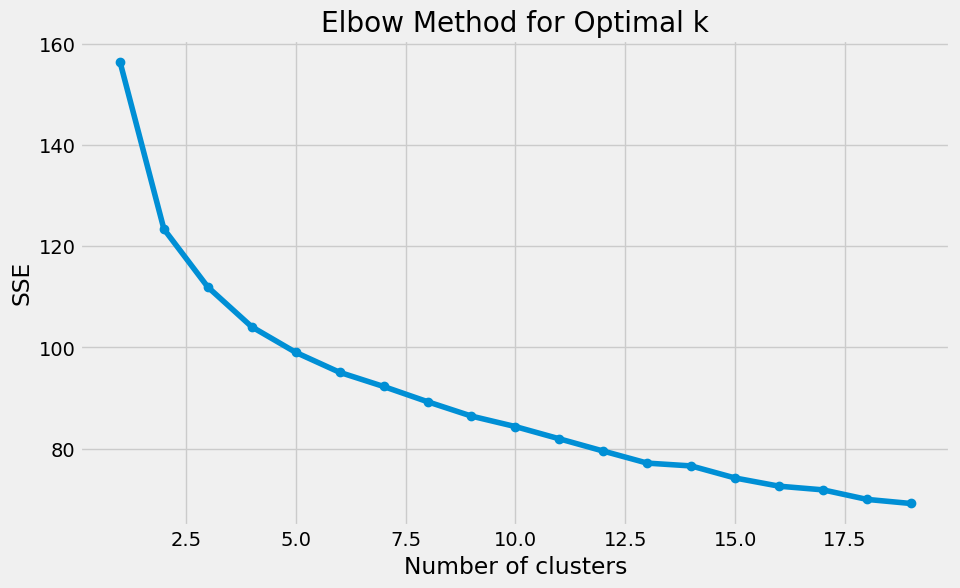

In [ ]:
X = np.stack(data_clean['vector'].values)

sse = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()


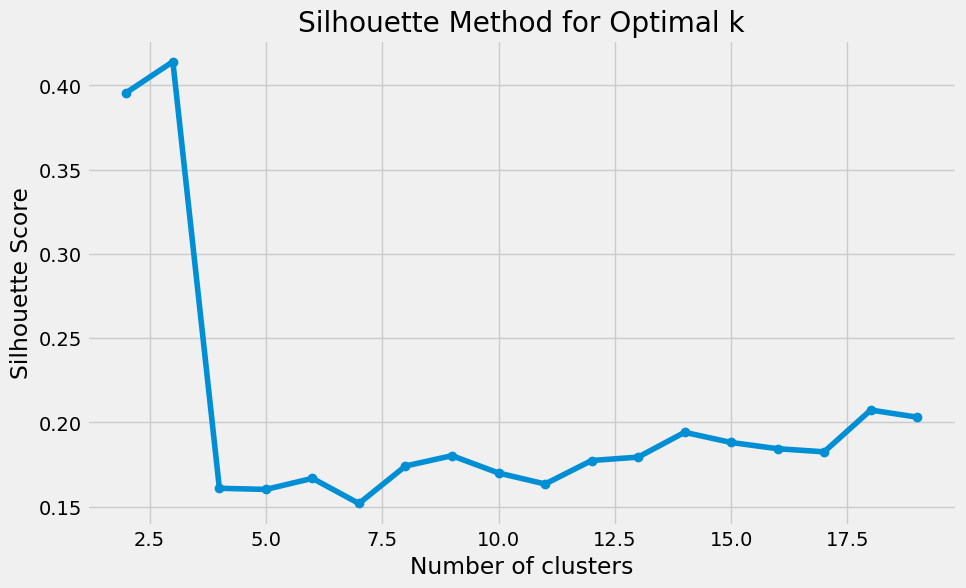

In [ ]:
silhouette = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    silhouette.append(silhouette_score(X, kmeans.labels_))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), silhouette, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

I will use 3 as the optimal number of clusters

In [ ]:
num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(np.stack(data_clean['vector'].values))
data_clean['cluster'] = kmeans.labels_

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf=True, stop_words='english')
matrix = vectorizer.fit_transform(data_clean['text'])
feature_names = vectorizer.get_feature_names_out()

for i in [range(num_clusters)]:
    cluster_texts = data_clean[data_clean['cluster'] == i]['text']
    tfidf_matrix = vectorizer.transform(cluster_texts)
    sum_words = tfidf_matrix.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    print(f'Cluster {i}:')
    for word, freq in words_freq[:5]:
        print(word)
    print()

Cluster 0:
brady
nfl
tom
huffpost
retires

Cluster 1:
biden
said
house
president
trump

Cluster 2:
factset
provided
data
rewritten
redistributed

